# Populations of Spiking Neurons
Set up a population of leaky integrate-and-fire neurons and run a simulation on the neurons to create spikes for visualizing.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

### LIF Population Model
Membrane updates are $$ v_{t+1} = v_{t} + (dt/tau_m) * ((v_{rest} - v_t) + R * I_{tot}) $$
where v_t is the voltage at time $t$, dt is the time, $tau_m$ is the membrane time constant, R is the resistance, I_{tot} = I_{ext} + I_{rec} = the externally injected current plus the recurrent synaptic current. For voltage: $v_{rest}$ is the resting potential, spikes are ommitted if $v >= v_{th}$ where $v_{th}$ is the voltage threshold. After a spike then the voltage is set back to $v_{reset}$.

We can think of $dt/tau_m$ as a control of the amount we can move in one timestep. The drive term is $R*I_{tot}$ which converts current into the effective voltage. And the leak tern is $v_{rest} - v_t$.

In [ ]:
@dataclass
class LIFPopulation:
    N: int = 200 # number of nodes
    frac_inh: float = 0.20 # fraction of the nodes that are inhibitory

    # Membrane parameters, numeric constants for the update rule
    tau_m: float = 20e-3
    v_rest: float = -65e-3
    v_reset: float = -65e-3
    v_th: float = -50e-3
    R: float = 10e6  # Ohms

    # Optional recurrent synapses (E positive, I negative)
    use_recurrent: bool = True
    tau_syn: float = 5e-3            # synaptic current decay time constant
    K_out: int = 50                  # outgoing connections per neuron
    w_e: float = 0.15e-9             # A (current jump per E spike to each target)
    w_i: float = -0.60e-9            # A (negative current jump per I spike to each target)
    seed: int = 0

    # State (initialized in __post_init__), the memory of the system
    rng: np.random.Generator = field(init=False, repr=False)
    v: np.ndarray = field(init=False)        # membrane voltage (V)
    I_rec: np.ndarray = field(init=False)    # recurrent synaptic current (A)

    # E/I identity, just changes the sign of the outgoing edge
    is_inh: np.ndarray = field(init=False)   # bool mask
    is_exc: np.ndarray = field(init=False)   # bool mask

    # Connectivity (post targets + weights per presyn neuron), adjacency list but vectorized
    post: np.ndarray = field(init=False)     # shape (K_out, N) int32
    w: np.ndarray = field(init=False)        # shape (K_out, N) float32

    def __post_init__(self):
        self.rng = np.random.default_rng(self.seed)

        # E/I split
        n_inh = int(round(self.frac_inh * self.N))
        inh_idx = self.rng.choice(self.N, size=n_inh, replace=False)
        self.is_inh = np.zeros(self.N, dtype=bool)
        self.is_inh[inh_idx] = True
        self.is_exc = ~self.is_inh

        # State
        self.v = np.full(self.N, self.v_rest, dtype=np.float32)
        self.I_rec = np.zeros(self.N, dtype=np.float32)

        # Connectivity
        if self.use_recurrent and self.K_out > 0:
            self._build_random_connectivity()

    def reset_state(self, v: float | None = None):
        """Reset voltages and recurrent synaptic current."""
        self.v.fill(self.v_rest if v is None else v)
        self.I_rec.fill(0.0)

    def _build_random_connectivity(self):
        # Random posts (allow duplicates for speed; fine for toy sims)
        post = self.rng.integers(0, self.N, size=(self.K_out, self.N), dtype=np.int32)

        # Avoid self-connection cheaply (not perfect, but good enough)
        cols = np.arange(self.N, dtype=np.int32)
        mask_self = (post == cols[None, :])
        post[mask_self] = (post[mask_self] + 1) % self.N

        # Dale-like sign: presyn E => +w_e, presyn I => w_i (negative)
        w_pre = np.where(self.is_exc, self.w_e, self.w_i).astype(np.float32)
        w = np.broadcast_to(w_pre[None, :], (self.K_out, self.N)).copy()

        self.post = post
        self.w = w

    def step(self, I_ext: np.ndarray, dt: float) -> np.ndarray:
        """
        Advance population by one timestep.
        I_ext: external current per neuron (A), shape (N,)
        Returns: spikes (bool), shape (N,)
        """
        I_ext = np.asarray(I_ext, dtype=np.float32)
        if I_ext.shape != (self.N,):
            raise ValueError(f"I_ext must have shape ({self.N},), got {I_ext.shape}")

        # Decay recurrent synaptic current
        if self.use_recurrent and self.tau_syn > 0:
            self.I_rec *= np.exp(-dt / self.tau_syn).astype(np.float32)

        # Total current
        I_tot = I_ext + (self.I_rec if self.use_recurrent else 0.0)

        # Euler membrane update
        dv = (dt / self.tau_m) * ((self.v_rest - self.v) + self.R * I_tot)
        self.v = self.v + dv.astype(np.float32)

        # Threshold + reset
        spikes = self.v >= self.v_th
        if np.any(spikes):
            self.v[spikes] = self.v_reset

            # Inject synaptic current into posts from spiking presyn neurons
            if self.use_recurrent and self.K_out > 0:
                spk_idx = np.flatnonzero(spikes).astype(np.int32)
                posts = self.post[:, spk_idx].ravel()
                ws = self.w[:, spk_idx].ravel()
                np.add.at(self.I_rec, posts, ws)

        return spikes


### Simulation Runner

In [23]:
def run_simulation(
    pop: LIFPopulation,
    T: float = 1.0,
    dt: float = 1e-4,
    I_ext_mean: float = 1.5e-9,
    I_ext_std: float = 0.5e-9,
    seed: int = 123,
    record_v: bool = False,
):
    rng = np.random.default_rng(seed)
    steps = int(T / dt)

    spikes = np.zeros((steps, pop.N), dtype=bool)
    v_hist = np.zeros((steps, pop.N), dtype=np.float32) if record_v else None

    for t in range(steps):
        I_ext = rng.normal(I_ext_mean, I_ext_std, size=pop.N).astype(np.float32)
        s = pop.step(I_ext, dt)
        spikes[t] = s
        if record_v:
            v_hist[t] = pop.v

    # Simple summary stats (group firing rates in Hz)
    exc_rate_hz = spikes[:, pop.is_exc].sum() / (T * pop.is_exc.sum())
    inh_rate_hz = spikes[:, pop.is_inh].sum() / (T * pop.is_inh.sum())

    return spikes, v_hist, {"exc_rate_hz": exc_rate_hz, "inh_rate_hz": inh_rate_hz}


### Run Simulation on Model

In [ ]:
pop = LIFPopulation(
    N=1000,
    frac_inh=0.2,
    use_recurrent=True,
    tau_syn=5e-3,
    K_out=50,
    w_e=0.10e-9,
    w_i=-0.50e-9,
    seed=0,
)

dt = 1e-4
T = 1.0

spikes, v_hist, stats = run_simulation(
    pop,
    T=T,
    dt=dt,
    I_ext_mean=1.5e-9,
    I_ext_std=0.5e-9,
    record_v=False,
)
print(stats)
print("Total spikes:", spikes.sum())


{'exc_rate_hz': np.float64(10.27125), 'inh_rate_hz': np.float64(10.165)}
Total spikes: 10250


## Raster Plot
Used as a first diagnostic for a spiking simulation. Who spiked when? Vertical bands will indicate that many neurons fired at once — are there long pauses in the network? Horizontal bands indicate that one neuron is firing repeatedly — are there neurons spiking rarely or frequently? With large networks it's advantageous to plot a subset of neurons.

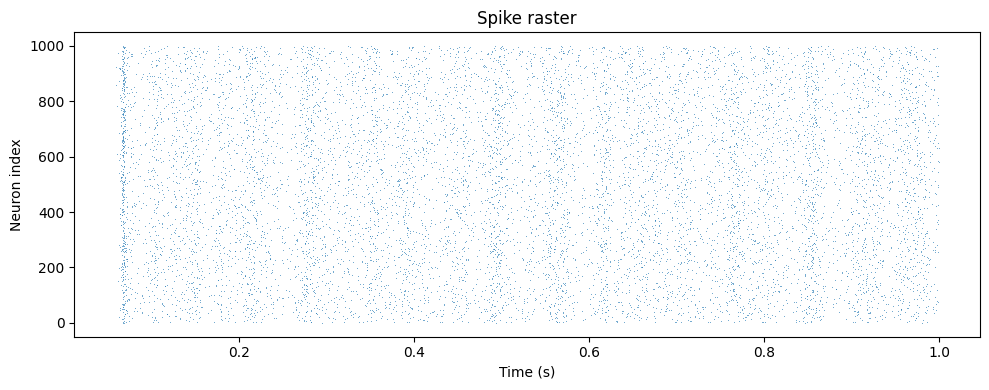

In [33]:
t_idx, n_idx = np.where(spikes)          # indices of True entries
t = t_idx * dt                           # seconds

plt.figure(figsize=(10, 4))
plt.scatter(t, n_idx, s=1, marker='.', linewidths=0)
plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.title("Spike raster")
plt.tight_layout()
plt.show()


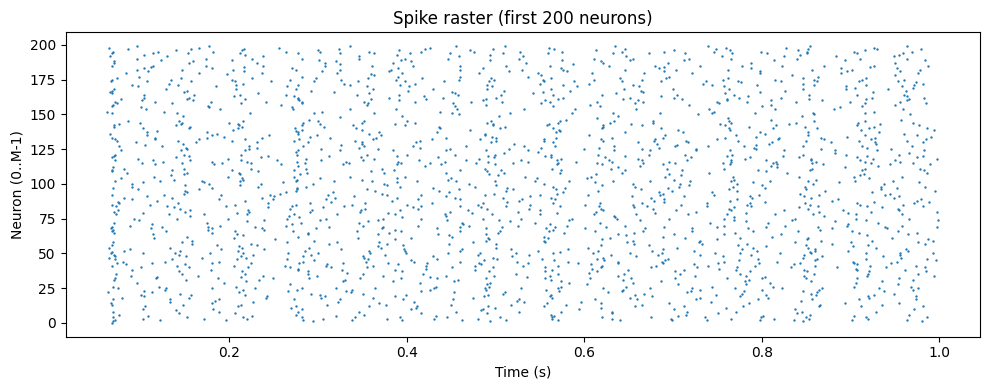

In [34]:
# Subset of raster
M = 200
t_idx, n_idx = np.where(spikes[:, :M])
plt.figure(figsize=(10, 4))
plt.scatter(t_idx*dt, n_idx, s=2, marker='.')
plt.xlabel("Time (s)"); plt.ylabel("Neuron (0..M-1)")
plt.title(f"Spike raster (first {M} neurons)")
plt.tight_layout(); plt.show()


# Firing Rate over Time
Used for comparing conditions or checking stability. Here we compress the rastor into a single timeseries. When does the network settle? When does it ramp up or down? Is the network quiet, bursty or roughly stationary?

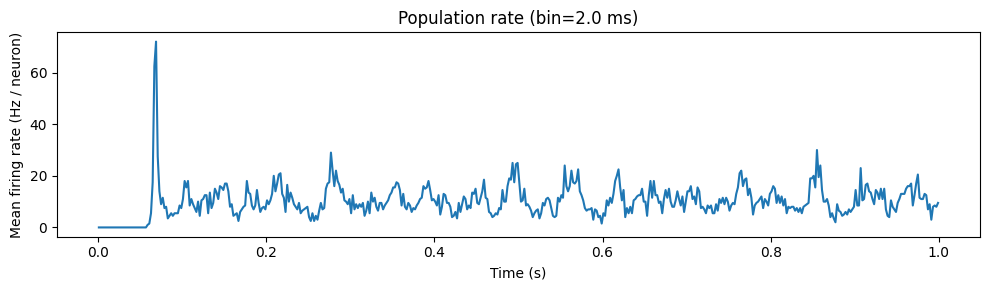

In [35]:
T = 1.0
dt = 1e-4
N = spikes.shape[1]

bin_ms = 2.0
bin_w = int((bin_ms * 1e-3) / dt)  # bin width in steps
bin_w = max(bin_w, 1)

steps = spikes.shape[0]
trim = steps - (steps % bin_w)
S = spikes[:trim].reshape(-1, bin_w, N).sum(axis=1)   # spikes per bin per neuron
pop_counts = S.sum(axis=1)                            # total spikes per bin

bin_dt = bin_w * dt
rate_hz = pop_counts / (N * bin_dt)                   # average Hz per neuron
t_bins = (np.arange(len(rate_hz)) + 0.5) * bin_dt

plt.figure(figsize=(10, 3))
plt.plot(t_bins, rate_hz)
plt.xlabel("Time (s)")
plt.ylabel("Mean firing rate (Hz / neuron)")
plt.title(f"Population rate (bin={bin_ms} ms)")
plt.tight_layout()
plt.show()


## Per-Neuron Firing Rate Distribution
How is activity distributed across neurons? Is activity evenly spread? Is the population balanced? 

Note: doesn't consider timing

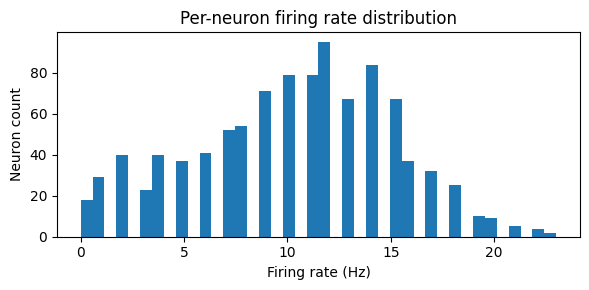

In [36]:

rates = spikes.sum(axis=0) / T  # spikes/sec per neuron (Hz)

plt.figure(figsize=(6, 3))
plt.hist(rates, bins=40)
plt.xlabel("Firing rate (Hz)")
plt.ylabel("Neuron count")
plt.title("Per-neuron firing rate distribution")
plt.tight_layout()
plt.show()


## Heat Map
Image like view of spiking in a time window. Easier to scan for patterns.

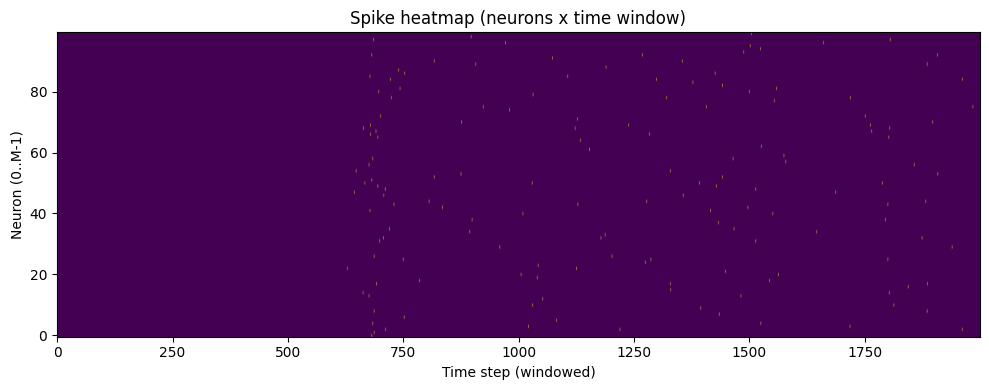

In [37]:
dt = 1e-4
M = 100          # neurons to show
t0, t1 = 0.0, 0.2
i0, i1 = int(t0/dt), int(t1/dt)

plt.figure(figsize=(10, 4))
plt.imshow(spikes[i0:i1, :M].T, aspect='auto', origin='lower')
plt.xlabel("Time step (windowed)")
plt.ylabel("Neuron (0..M-1)")
plt.title("Spike heatmap (neurons x time window)")
plt.tight_layout()
plt.show()


## Animated Graph of Network

NOTE: Placeholder here, not representing the network above.

Saved spiking_simulation.mp4


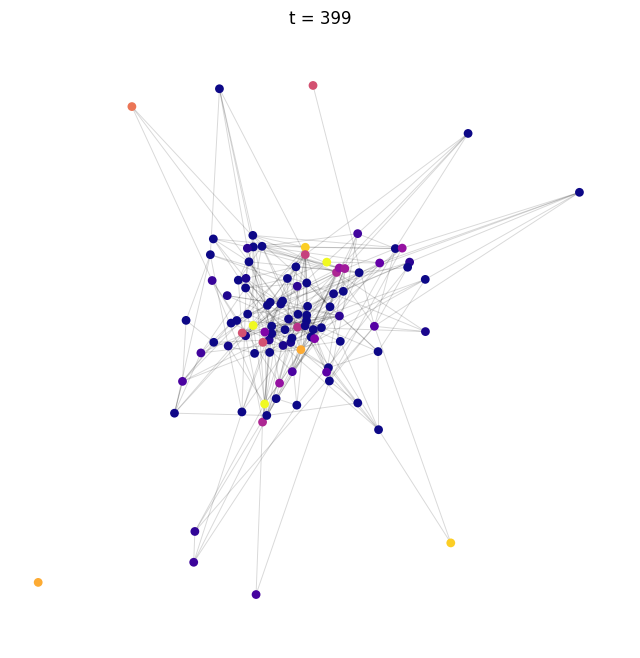

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Example: build a random directed graph
N = 100
p = 0.03
rng = np.random.default_rng(0)

G = nx.DiGraph()
G.add_nodes_from(range(N))
for i in range(N):
    for j in range(N):
        if i != j and rng.random() < p:
            G.add_edge(i, j)

# Example spike log: spikes_by_t is a list of arrays (indices)
T = 400
spikes_by_t = []
for t in range(T):
    spikers = np.flatnonzero(rng.random(N) < 0.01)  # toy
    spikes_by_t.append(spikers)

# Layout (fixed positions so animation doesn't jump)
pos = nx.spring_layout(G, seed=1)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_axis_off()

# Draw edges once (static)
nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.15, arrows=False, width=0.7)

# Node artist: we will update colors each frame
nodes = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=40,
    node_color="lightgray",
    linewidths=0.0
)

# Optional: "glow" that decays over time so spikes linger a bit
glow = np.zeros(N, dtype=np.float32)
decay = 0.90  # closer to 1.0 = longer persistence

def update(frame):
  global glow
  glow *= decay
  glow[spikes_by_t[frame]] = 1.0

  # Map glow to colors: gray baseline -> hot when spiking
  # You can replace this with any colormap you like
  colors = plt.cm.plasma(glow)  # RGBA array (N, 4)
  nodes.set_facecolor(colors)

  ax.set_title(f"t = {frame}", fontsize=12)
  return (nodes,)

ani = FuncAnimation(fig, update, frames=T, interval=30, blit=True)
# Save to MP4
fps = 30
writer = FFMpegWriter(fps=fps, bitrate=1800)
ani.save("spiking_simulation.mp4", writer=writer, dpi=200)

print("Saved spiking_simulation.mp4")
